**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an amazing job, really going beyond expectations at this point! :)
I left a couple of suggestions for improvements below. The project is accepted. Keep up the great work on the next sprint!


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import time

In [5]:
df = pd.read_csv("/datasets/users_behavior.csv")
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected

</div>

## Split data

In [8]:
X = df.drop('is_ultra', axis=1)
y = df['is_ultra']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train, validation and test sets. The proportions are reasonable

</div>

## Training

### Calculate the metrics

Since the approach to calculate the accuracy won't change regardless which model will be chosen. I'll make a function to calculate it and call it in each model experiment.

I will use the following metrics to evaluate classification models.

#### Accuracy

Accuracy is the most straightforward indicator of the model performance. It measure the percentage of accurate predictions: 

$$accuracy = \frac{(TP + TN)}{Total\ number\ of\ all\ samples}$$

#### AUC

AUC is the area under the ROC curve (ROC is the plot of true positive rate against false positive rate at various classification threshold), and higher AUC indicates better model performance.

#### Confusion matrix

Confusion matrix indicates the actual values vs. predicted values and summarize the TN, FP, FN and TP values in a matrix format.

![img](https://scikit-learn.org/stable/_images/sklearn-metrics-ConfusionMatrixDisplay-1.png)

#### F1 Score

The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. 

$$ F1 = \frac{2*precision*recall}{precision+recall}=\frac{2*TP}{2*TP+FP+FN}$$

In [86]:
def calculate_acc(y_pred, y_test, model):
    score = round(metrics.accuracy_score(y_test, y_pred), 3)  #  ({(TN+TP)/(TN+TP+FN+FP)})
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
    auc= round(metrics.auc(fpr, tpr), 3)
    con_matrix = confusion_matrix(y_test, y_pred)
    TN = con_matrix[0][0]
    FP = con_matrix[0][1]
    FN = con_matrix[1][0]
    TP = con_matrix[1][1]
    f1 = round(metrics.f1_score(y_test, y_pred, average='binary'), 3) # ({(2*TP)/(2*TP+FP+FN)})
    
    print(f"""
    The model is {model}:
    The accuracy is {score},
    The auc is {auc},
    The f1 score is {f1}.
    """)
    return score, auc, f1, con_matrix


<div class="alert alert-warning">
<b>Reviewer's comment</b>

It's nice that you used not just accuracy, but other classification metrics as well, but there is one problem here: for the ROC curve, and subsequently the area under the ROC curve we need different input from other metrics. For ROC-AUC we need probabilities (method `predict_proba`), while for other metrics you used we need binary predictions (method `predict`). The reason is that the ROC curve is constructed by varying the threshold of assigning positive class, and for binary predictions the threshold is predefined. ROC-AUC calculated using binary prediction underestimates the true ROC-AUC.
    
Also, a minor issue, but when you're referring to `auc` it's ambiguous. The ROC curve is not the only curve the area under which is used as a metric, even a classification metric. For example, there is PR-AUC: the area under the [precision-recall curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html).

</div>

### Model 1 -- Logistic Regression

**Logistic regression** uses sigmoid function above to return the probability of a label. It is widely used when the classification problem is binary — true or false, win or lose, positive or negative.

In this case, I consider the Logistic Regression as a baseline model, and won't tune the hyperparameters. So I'll make a function of traning and calculate metrics not only for Logistic Regression, but also for other models with default hyperparameters.

In [112]:
def default_training(model_obj, model_name, gridsearch=None, **kwargs):
    start = time.time()
    model_obj.fit(X_train, y_train)
    y_pred = model_obj.predict(X_val)
    score, auc, f1, con_matrix = calculate_acc(y_pred, y_val, model_name)
    disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix,
                               display_labels=model_obj.classes_)
    time_cost = round((time.time() - start), 3)
    print("The confusion matrix is:")
    disp.plot()
    plt.show()
    print(f"This training/testing process takes {time_cost}s.")
    


    The model is Logistic Regression:
    The accuracy is 0.763,
    The auc is 0.614,
    The f1 score is 0.387.
    
The confusion matrix is:


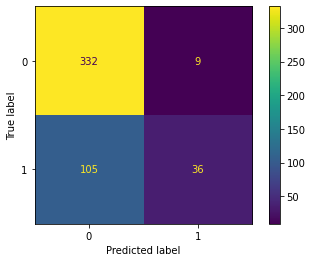

This training/testing process takes 0.041s.


In [113]:
log_reg = LogisticRegression(random_state=42)
default_training(log_reg, 'Logistic Regression')

The accuracy of basic Logistic Regression is 0.763, it seems OK, but the f1 score is only 0.387. We can find from the confusion matrix that there are 105 False Negative values. For the time consuming, this model takes 0.041s to train, it's fast.

### Model 2 -- Naive Bayes

Naive Bayes is based on Bayes’ Theorem — an approach to calculate conditional probability based on prior knowledge, and the naive assumption that each feature is independent to each other. The biggest advantage of Naive Bayes is that, while most machine learning algorithms rely on large amount of training data, it performs relatively well even when the training data size is small (our dataset only has 3400 observations). Gaussian Naive Bayes is a type of Naive Bayes classifier that follows the normal distribution.

Since the model is straightforward, and it doesn't have many hyperparameters to tune. I'll use it with default setting.


    The model is Naive Bayes with default hyperparameters:
    The accuracy is 0.797,
    The auc is 0.707,
    The f1 score is 0.585.
    
The confusion matrix is:


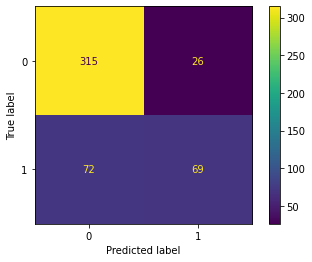

This training/testing process takes 0.013s.


In [114]:
gnb = GaussianNB()
default_training(gnb, 'Naive Bayes with default hyperparameters')

The Naive Bayes performs better than the Logistic Regression. The accuracy is 0.797 and the f1 score is 0.585. For time consuming, the train process takes 0.013s. Super fast.

### Model 3 -- Decision Tree

**Decision tree** builds tree branches in a hierarchy approach and each branch can be considered as an if-else statement. The branches develop by partitioning the dataset into subsets based on most important features. Final classification happens at the leaves of the decision tree.

I'll run the model with default setting first, then I'll apply the grid search to find the best hyperparameters.

#### Default hyperparameters


    The model is Decision Tree with default hyperparameters:
    The accuracy is 0.728,
    The auc is 0.679,
    The f1 score is 0.547.
    
The confusion matrix is:


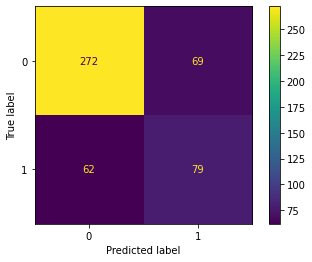

This training/testing process takes 0.023s.


In [117]:
dtc_default = DecisionTreeClassifier(random_state=42)
default_training(dtc_default, 'Decision Tree with default hyperparameters')

The Decision Tree performs similar to the Naive Bayes, but if we check the confusion matrix carefully, we can find there are many False Positive and False Negative values, at the same time, this model picks many True Negative values out.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you tried a couple of different models and compared the results using the validation set

</div>

#### Fine tune the model

In [145]:
def grid_search(model_obj, param_grid):
    start = time.time()
    grid_search = GridSearchCV(model_obj,param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    time_cost = round((time.time() - start), 3)
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)
    print(f"The time of execution of above program is {time_cost} s")
    return grid_search.best_params_

<div class="alert alert-success">
<b>Reviewer's comment</b>

It's cool that you used a grid search with cross-validation to tune the models' hyperparameters!

</div>

In [146]:
dtc_grid = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 7, 10]
}
best_params_dtc = grid_search(dtc_grid, param_grid)

Best parameters:  {'max_depth': 5, 'min_samples_split': 5}
Best score:  0.7874595397178916
The time of execution of above program is 1.03 s



    The model is Decision Tree with best hyperparameters:
    The accuracy is 0.795,
    The auc is 0.682,
    The f1 score is 0.54.
    
The confusion matrix is:


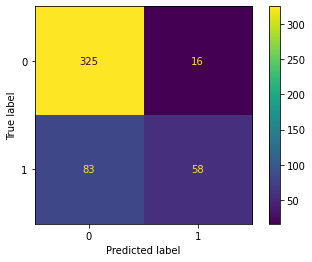

This training/testing process takes 0.013s.


In [148]:
best_dtc_classifier = DecisionTreeClassifier(random_state=42,
                                             max_depth=best_params_dtc['max_depth'],
                                            min_samples_split=best_params_dtc['min_samples_split'])
default_training(best_dtc_classifier, 'Decision Tree with best hyperparameters')

After grid searching, I found the relatively best hyperparameters, and the model performed better than it with default setting.

The accuracy and auc increases to 0.795 and 0.682. In confusion matrix, the recognition of TN values increase significantly, but the f1 score decreases a little bit, since the TP values of this model are less than the default model. 

### Model 4 -- Random Forest

The **random forest** is a collection of decision trees. It is a common type of ensemble methods which aggregate results from multiple predictors. Random forest additionally utilizes bagging technique that allows each tree trained on a random sampling of original dataset and takes the majority vote from trees. Compared to decision tree, it has better generalization but less interpretable, because of more layers added to the model.

I'll run the model with default setting first, then I'll apply the grid search to find the best hyperparameters.

####  Default hyperparameters


    The model is Random Forest with default hyperparameters:
    The accuracy is 0.828,
    The auc is 0.749,
    The f1 score is 0.656.
    
The confusion matrix is:


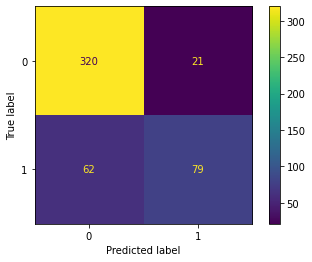

This training/testing process takes 0.599s.


In [121]:
rfc_default = RandomForestClassifier(random_state=42)
default_training(rfc_default, 'Random Forest with default hyperparameters')

#### Fine tune hyperparameters

In [149]:
param_grid = {
    'n_estimators': [2, 4, 8, 16, 32, 64, 128],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 7, 10],
    'random_state': [42]
}
best_params_rfc = grid_search(rfc_default, param_grid)

Best parameters:  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 16, 'random_state': 42}
Best score:  0.8119039841623362
The time of execution of above program is 89.249 s



    The model is Random Forest with best hyperparameters:
    The accuracy is 0.832,
    The auc is 0.744,
    The f1 score is 0.649.
    
The confusion matrix is:


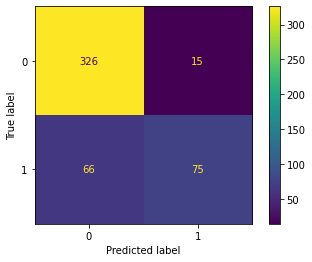

This training/testing process takes 0.083s.


In [150]:
best_rf_classifier = RandomForestClassifier(n_estimators=best_params_rfc['n_estimators'],
                                            max_depth=best_params_rfc['max_depth'],
                                            min_samples_split=best_params_rfc['min_samples_split'], random_state=42)
default_training(best_rf_classifier, 'Random Forest with best hyperparameters')

The whole performance of Random Forest is better than the Decision Tree. Even with the default setting, the metrics are better than the Decision Tree with best hyperparameters.

After grid searching, the accuracy is 0.832 which is the best currently. The f1 score is 0.649.

### Model 5 -- XGBoost

**XGBoost** stands for “Extreme Gradient Boosting” and it is an ensemble learning method that combines the predictions of multiple weak models to produce a stronger prediction.

I'll run the model with default setting first, then I'll apply the grid search to find the best hyperparameters.

####  Default hyperparameters

[04:23:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

    The model is XGBoost with default hyperparameters:
    The accuracy is 0.83,
    The auc is 0.757,
    The f1 score is 0.667.
    
The confusion matrix is:


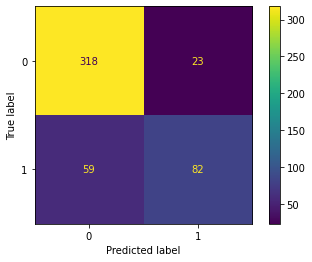

This training/testing process takes 1.298s.


In [120]:
xgb_default = xgb.XGBClassifier(use_label_encoder=False)
default_training(xgb_default, 'XGBoost with default hyperparameters')

In [154]:
xgb_default

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

#### Fine tune hyperparameters

In [155]:
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False)
param_grid = {
    'n_estimators': [64, 100, 128],
    'learning_rate': [0.35, 0.3, 0.2, 0.1, 0.05],
    'max_depth': [3, 5, 6, 7]
}
best_params_xgb = grid_search(xgb_classifier, param_grid)

[14:52:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:03:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

    The model is XGBoost with best hyperparameters:
    The accuracy is 0.822,
    The auc is 0.737,
    The f1 score is 0.636.
    
The confusion matrix is:


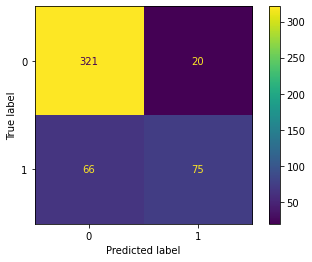

This training/testing process takes 8.483s.


In [156]:
best_xgb_classifier = xgb.XGBClassifier(n_estimators=best_params_xgb['n_estimators'],
                                        learning_rate=best_params_xgb['learning_rate'],
                                        max_depth=best_params_xgb['max_depth'],
                                       use_label_encoder=False)
default_training(best_xgb_classifier, 'XGBoost with best hyperparameters')

The XGBoost with the default setting performs best throughout the experiment. The accuracy is 0.83, auc is 0.757, and the f1 score is 0.667.

I didn't find the best hyperparameters from the grid search even I've put the default three hyperparameters into the grid list. I'll use the default model when testing.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Yeah, the defaults can often be pretty good, and tuning hyperparameters is not that straighforward. As doing an exhaustive grid search is prohibitively expensive in time, [radnomization](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) is often employed, especially in the form of 
[bayesian optimization](https://distill.pub/2020/bayesian-optimization/) (e.g. with [optuna](https://optuna.org/))
</div>

## Test

In [159]:
model_list = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost']
model_pipeline = [log_reg, gnb, best_dtc_classifier, best_rf_classifier, xgb_default]
time_consume = [0.041, 0.013, 0.013, 0.083, 1.298]
acc_list = []
auc_list = []
cm_list = []
f1_list = []


for model in model_pipeline:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
    auc_list.append(round(metrics.auc(fpr, tpr), 3))
    cm_list.append(confusion_matrix(y_test, y_pred))
    f1_list.append(round(metrics.f1_score(y_test, y_pred, average='binary'), 3))


result_df = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list, 'F1 Score': f1_list, 'Time Consume (S)': time_consume})
result_df

[15:30:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Accuracy,AUC,F1 Score,Time Consume (S)
0,Logistic Regression,0.722567,0.605,0.368,0.041
1,Naive Bayes,0.772257,0.693,0.570,0.013
2,Decision Tree,0.772257,0.687,0.556,0.013
3,Random Forest,0.792961,0.716,0.609,0.083
4,XGBoost,0.784679,0.724,0.629,1.298


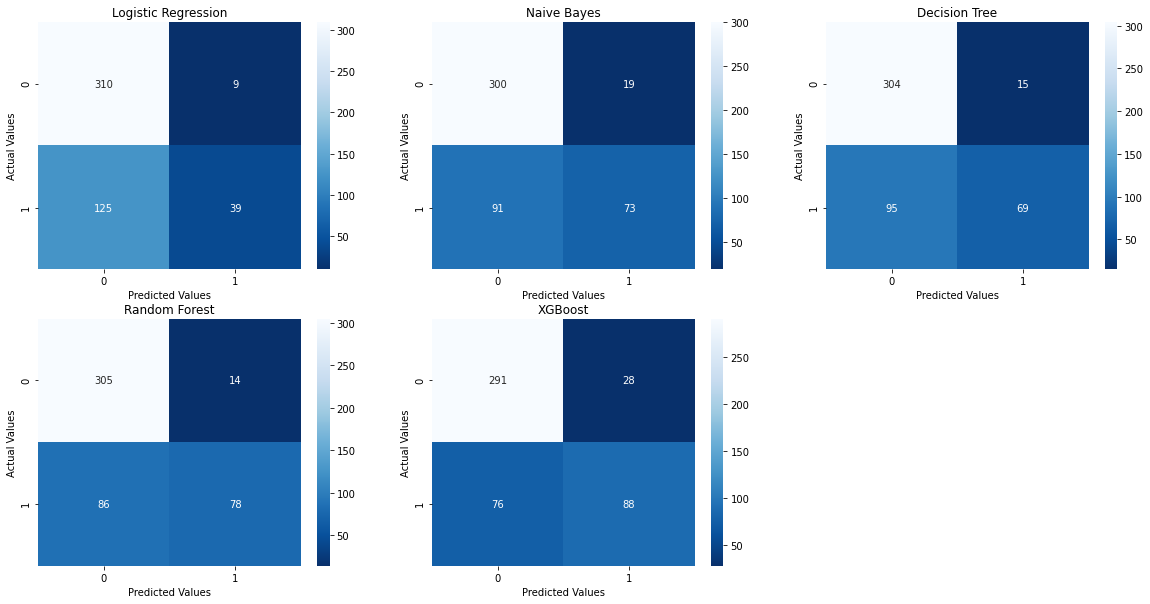

In [160]:
fig = plt.figure(figsize=(20, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    cm_plot = sns.heatmap(cm, annot=True, cmap="Blues_r", fmt='d')
    cm_plot.set_xlabel('Predicted Values')
    cm_plot.set_ylabel('Actual Values')

Implementing on the test set, the performance of these 5 models can be split into 3 groups. 
1. The Logistic Regression performs the worst. Its accuracy is only 0.723, it also predict the least TP values.
2. The Naive Bayes and Decision Tree have similar accuracies which are arounding 0.77.
3. The best group models are the Random Forest and the XGBoost. For the accuracy, the Random Forest is 0.793 which is better a little bit than the XGBoost. But the auc and f1 score of XGBoost is better, especially for the f1 score, the XGBoost predicted 10 more values than the Random Forest. But if we consider the time consume, the time cost of XGBoost is 16 times more than the Random Forest.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Note that if we use the test set to choose the best model, it is not possible to use the same test set to obtain unbiased estimate of the final selected model's generalization performance (because the test set was used to make a decision about the model). So the test set is often left to evaluate only the final model, while the validation set is used to compare different models.

</div>

## Conclusion

In this project, I implemented 5 models to make the classification experiment.

At first, I used the default setting of these models, then I applied grid search to find the best hyperparameters of Decision Tree, Random Forest and XGBoost. After optimized, these models performed better than with the default settings.

For metrics, I used the accuracy, the auc score and the f1 score. I noticed that the f1 scores of all models were less than 0.65. The main reason is the dataset is not balance enough, there are only a few True Positive values while with lots of True Negative values, but the TN values doesn't affact the f1 score.

During testing, the performance of these 5 models can be split into 3 groups. The Logistic Regression performs the worst, the Navie Bayes and Decision Tree are in the middle, and the 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Conclusions make sense! Again, it's great that you explored different metrics and not just accuracy.

</div>